# Vary risk aversion and decision type in the decision context

In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [2]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### 7th day ahead forecast for Murray at Biggara (401012) generated using the MuTHRE method

In [3]:
dataset_filepath = 'example_data.pickle.bz2'
parallel_nodes = 8
alpha_step = 0.02
verbose = False

In [4]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(276,) (276, 100) (276, 496)


# Define decision context

In [5]:
decision_definition = {
    'alphas': np.array([0.6]),
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.5, 'threshold': np.nanquantile(obs, 0.9)}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_method': 'optimise_over_forecast_distribution'
}

ref = clim_ens  # use 14-day moving average climatology as reference forecast (pre-caulcated in example dataset)

# Define sets of risk aversion and decision type

In [6]:
risk_aversions = np.arange(0, 100, 2)
decision_types = ['Binary', 'Multicategorical', 'Continuous']

# Calculate RUV over these sets

### Complete the decision context using each combination of risk aversion and decision type before calculating RUV

In [7]:
results = pd.DataFrame(columns=decision_types, index=risk_aversions)

for risk_aversion in risk_aversions:
    decision_definition['utility_function'] = [cara, {'A': risk_aversion}]
    
    for decision_type in decision_types:
        if verbose:
            print(risk_aversion, decision_type)

        if decision_type == 'Binary':
            decision_definition['decision_thresholds'] = np.nanquantile(obs, [0, 0.75])
        elif decision_type == 'Multicategorical':
            decision_definition['decision_thresholds'] = np.nanquantile(obs, [0, 0.1, 0.25, 0.5, 0.75, 0.9])
        elif decision_type == 'Continuous':
            decision_definition['decision_thresholds'] = None

        result = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes, verbose)
        results.loc[risk_aversion, decision_type] = result['ruv'][0]

# Plot forecast value against risk aversion for each decision type

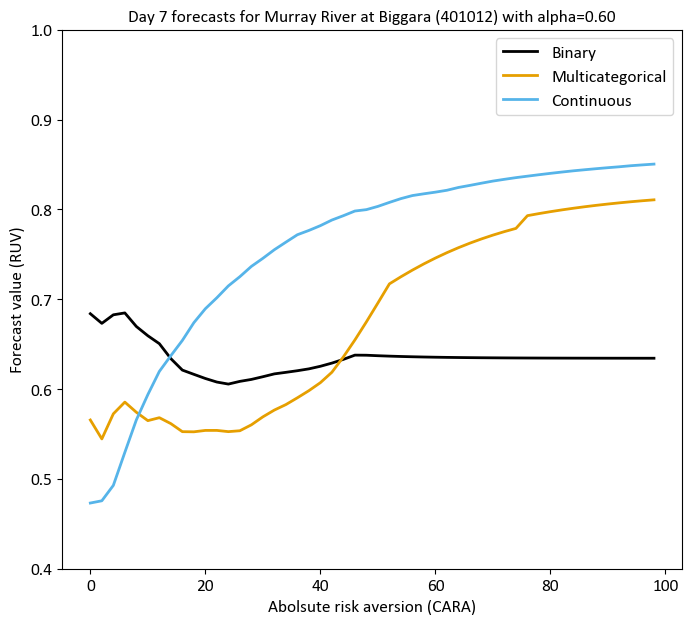

In [8]:
for i, decision_type in enumerate(decision_types):
    plt.plot(results[decision_type], color=list(colors.values())[i], linewidth=2, alpha=1.0, label=decision_type)
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.ylim(0.4, 1)
plt.xlabel('Abolsute risk aversion (CARA)')
plt.ylabel('Forecast value (RUV)')
plt.title('Day 7 forecasts for Murray River at Biggara (401012) with alpha=%.2f' % decision_definition['alphas'][0], fontsize='medium')
plt.legend()